# Objective (Part 2)

Evaluate 100 calibrated ensemble outputs for 4 model configurations

# Experiment description

* Chosen metric details (See: calib_metriceval_v2.ipynb): **exp7 - Daily KGE, 1 day smoothing, kge_a_alpha = 1.**
* 4 model runs
    * FUSE-PRMS
    * FUSE-HECHMS
    * FUSE-VIC
    * FUSE-SACSMA
    
# Conclusion
TBD

In [14]:
import glob,os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [15]:
outdir = '/glade/p/work/manab/ff/islandpark/output/allens2'
prms = sorted(glob.glob(outdir + '/*_111_runs_best*.nc'))
hechms = sorted(glob.glob(outdir + '/*_222_runs_best*.nc'))
vic = sorted(glob.glob(outdir + '/*_333_runs_best*.nc'))
sacsma = sorted(glob.glob(outdir + '/*_444_runs_best*.nc'))

prmsparam = sorted(glob.glob(outdir + '/*_111_para_best*.nc'))
hechmsparam = sorted(glob.glob(outdir + '/*_222_para_best*.nc'))
vicparam = sorted(glob.glob(outdir + '/*_333_para_best*.nc'))
sacsmaparam = sorted(glob.glob(outdir + '/*_444_para_best*.nc'))

In [16]:
def qextract(nclist):
    '''
    Extracts q from each ensemble and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    '''
    ncdat = np.empty([37,])
    for count, value in enumerate(nclist):
        ncout = xr.open_dataset(value)
        ncout = ncout.groupby('time.year').max()
        ncout = ncout.where((ncout.year > 1979), drop = True)
        q = ncout['q_routed'].values
        ncdat = np.c_[ncdat, q]
    ncdat = np.delete(ncdat,(0), axis=1)
    return(ncdat)

def vextract(nclist, ncvar):
    '''
    Extracts any variable from each ensemble and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    ncvar: Variable to be extracted
    '''
    var = np.empty([1,])
    for count, value in enumerate(nclist):
        nc = xr.open_dataset(value)
        ncv = nc[ncvar].values
        var = np.c_[var, ncv]
    
    var = np.delete(var,(0), axis=1)
    return(var)

In [17]:
# Prepare simulation data
prmsq = qextract(prms)
hechmsq = qextract(hechms)
vicq = qextract(vic)
sacsmaq = qextract(sacsma)

In [18]:
# Prepare observation data 
ncout = xr.open_dataset(sacsma[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

# FLOW DURATION CURVES

In [19]:
def plotfdc(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    
    qdat: Simulation data
    qobs: Observation data
    pylabel: Y-axis plot label
    ptitle: Title of the plot
    psave: Plot name for saving
    
    '''
    # Calculate exceedance levels of sim data
    exceedanceens = np.arange(1.,len(qdat)+1) /len(qdat)
    sortens = np.sort(qdat, axis=0)[::-1]

    qmeandat = qdat.mean(axis=1)
    
    # Calculate exceedance levels of mean simulated data
    exceedancemean = np.arange(1.,len(qmeandat)+1) /len(qmeandat)
    sortmean = np.sort(qmeandat, axis=0)[::-1]
    
    # Calculate exceedance levels of obs data
    exceedanceobs = np.arange(1.,len(obsdat)+1) /len(obsdat)
    sortobs = np.sort(obsdat, axis=0)[::-1]
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8))
    plt.fill_between(exceedanceens*100, np.min(sortens, axis=1),np.max(sortens, axis=1), label = "Sim Q Ensemble")
    plt.plot(exceedancemean*100, sortmean, label = 'Sim Q Mean', color='red')
    plt.plot(exceedanceobs*100, sortobs, label = 'Obs Q', color='black')
    plt.xlabel("Exceedence [%]")
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

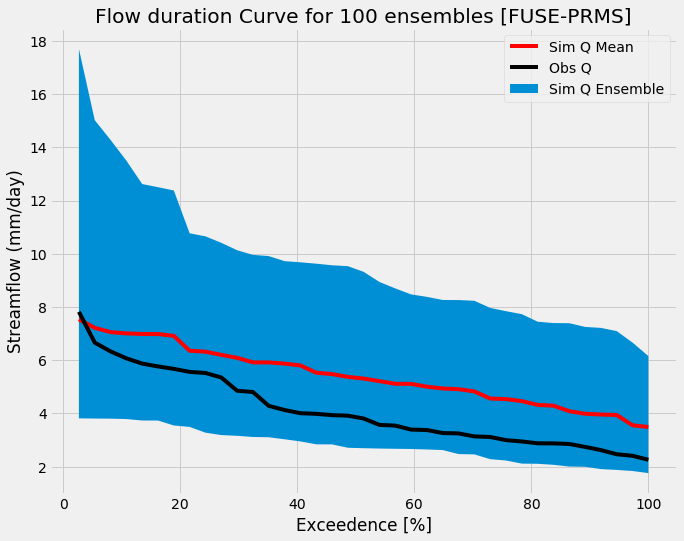

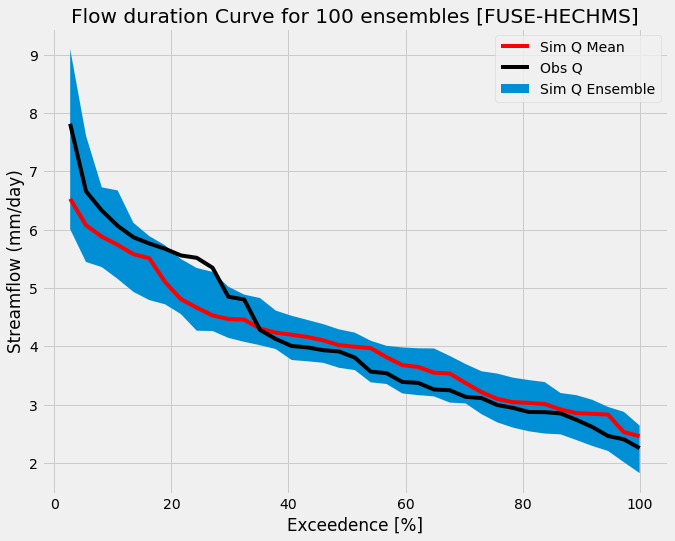

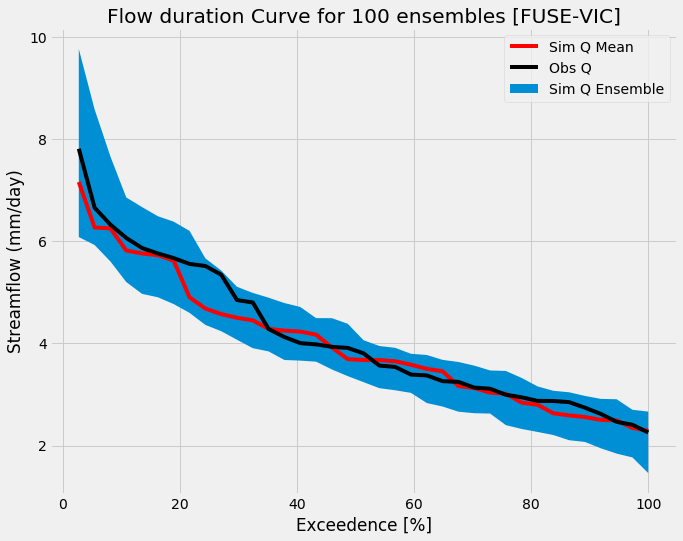

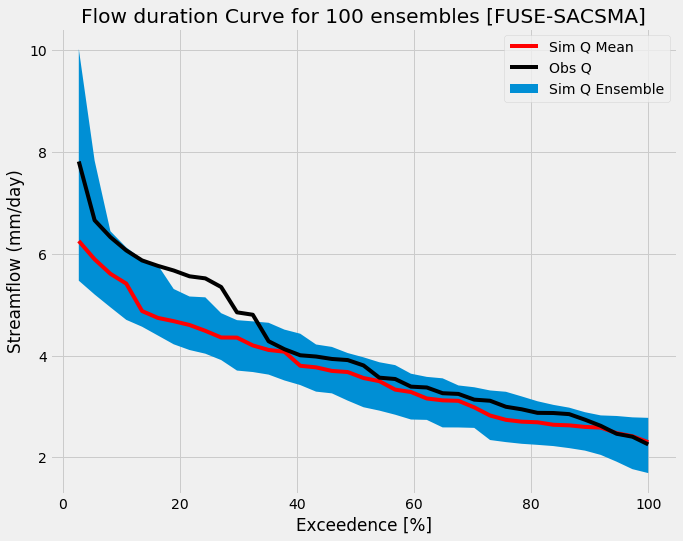

In [20]:
plotfdc(prmsq, qobs,'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-PRMS]', 'figures/fdcprms.png')
plotfdc(hechmsq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-HECHMS]', 'figures/fdchechms.png')
plotfdc(vicq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-VIC]', 'figures/fdcvic.png')
plotfdc(sacsmaq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-SACSMA]', 'figures/fdcsacsma.png')

# YEARLY PEAK FLOWS

In [21]:
def plotpeakq(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot peak flows of FUSE model outputs
    '''
    sort = np.flipud(np.sort(qdat, axis=0)[::-1])
    
    # Prepare mean ensemble data
    meanq = qdat.mean(axis=1)
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8)) 
    plt.plot(sort, color='lightblue')
    plt.plot(np.sort(meanq), label = 'Mean Q', color='red')
    plt.plot(np.sort(obsdat), label = 'Obs Q', color='black')
    plt.xlabel('')
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()
    
# Prepare observation data 
ncout = xr.open_dataset(prms[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

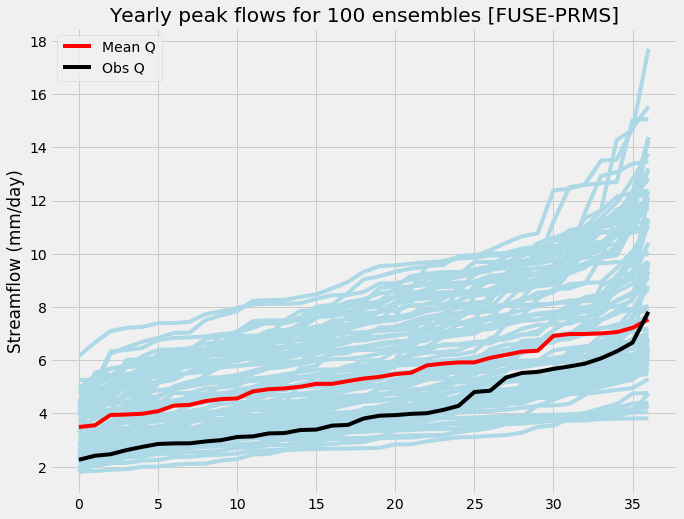

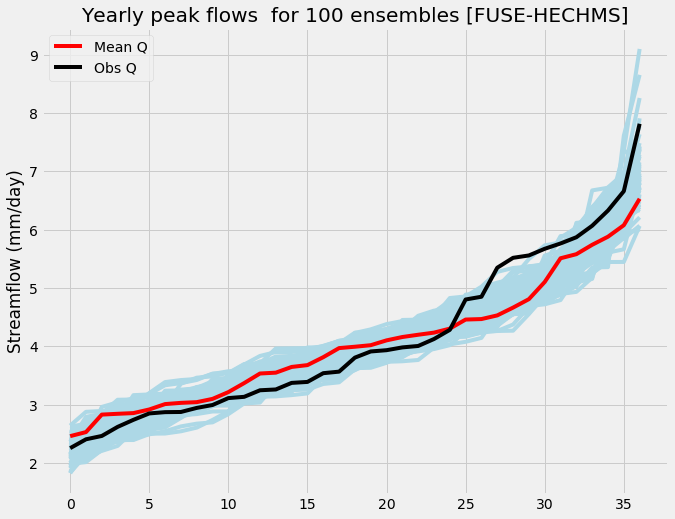

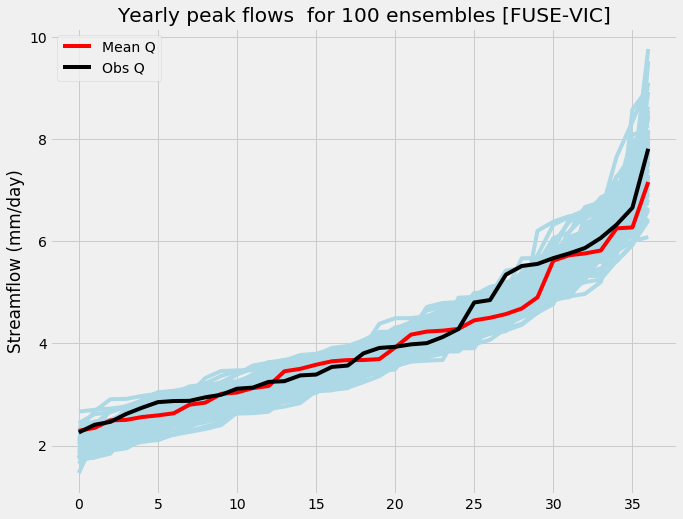

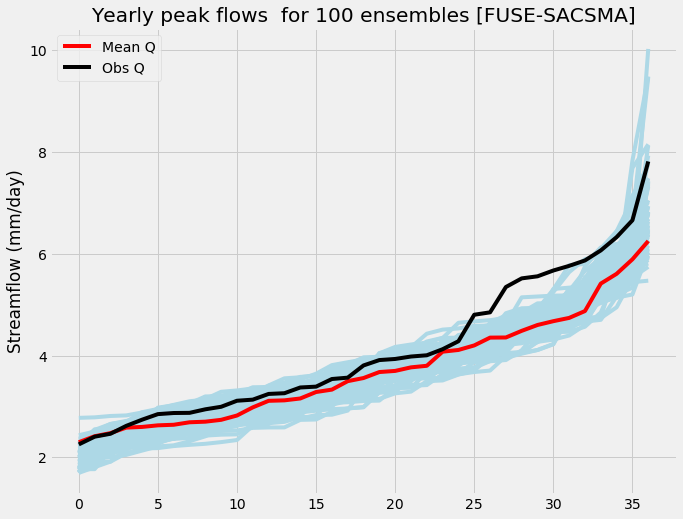

In [22]:
plotpeakq(prmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows for 100 ensembles [FUSE-PRMS]', 'figures/yearlyprms.png')
plotpeakq(hechmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-HECHMS]', 'figures/yearlyhecshms.png')
plotpeakq(vicq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-VIC]', 'figures/yearlyvic.png')
plotpeakq(sacsmaq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-SACSMA]', 'figures/yearlysacsma.png')

# Empirical CDF

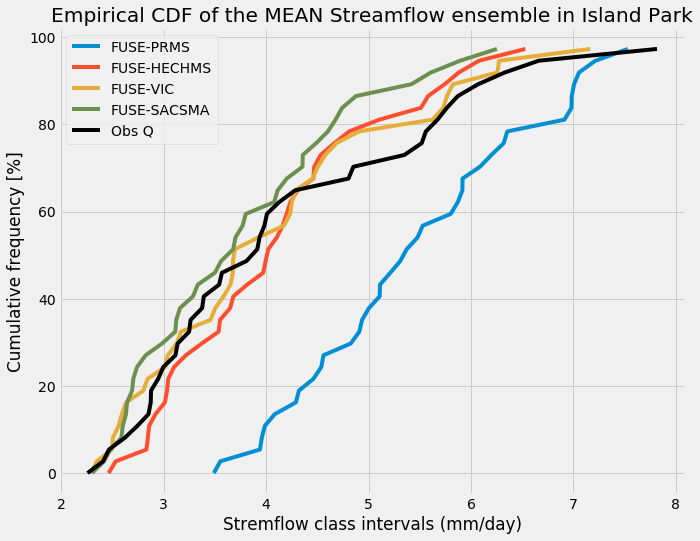

In [23]:
# Empirical CDF
plt.figure(figsize=(10,8))

meanprms = prmsq.mean(axis=1)
meanhechms = hechmsq.mean(axis=1)
meanvic = vicq.mean(axis=1)
meansacsma = sacsmaq.mean(axis=1)


plt.plot(np.sort(meanprms), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'FUSE-PRMS')
plt.plot(np.sort(meanhechms), np.linspace(0, 100, len(meanhechms), endpoint=False), label = 'FUSE-HECHMS')
plt.plot(np.sort(meanvic), np.linspace(0, 100, len(meanvic), endpoint=False), label = 'FUSE-VIC')
plt.plot(np.sort(meansacsma), np.linspace(0, 100, len(meansacsma), endpoint=False), label = 'FUSE-SACSMA')

plt.plot(np.sort(qobs), np.linspace(0, 100, len(qobs), endpoint=False), label = 'Obs Q', color = 'black')
plt.ylabel('Cumulative frequency [%]')
plt.xlabel('Stremflow class intervals (mm/day)')
plt.title('Empirical CDF of the MEAN Streamflow ensemble in Island Park')
plt.legend()
plt.savefig('figures/empiricalcdf.png', bbox_inches='tight', dpi=300)
plt.show()

# Range of KGE values

In [24]:
prmskge = vextract(prmsparam, 'kge')
hechmskge = vextract(hechmsparam, 'kge')
vickge = vextract(vicparam, 'kge')
sacsmakge = vextract(sacsmaparam, 'kge')                                                        

In [25]:
kge = {}
kge['Mean KGE (PRMS)'] = prmskge.mean()
kge['Max KGE (PRMS)'] = prmskge.max()
kge['Min KGE (PRMS)'] = prmskge.min()
kge['Mean KGE (HEC-HMS)'] = hechmskge.mean()
kge['Max KGE (HEC-HMS)'] = hechmskge.max()
kge['Min KGE (HEC-HMS)'] = hechmskge.min()
kge['Mean KGE (VIC)'] = vickge.mean()
kge['Max KGE (VIC)'] = vickge.max()
kge['Min KGE (VIC)'] = vickge.min()
kge['Mean KGE (SAC-SMS)'] = sacsmakge.mean()
kge['Max KGE (SAC-SMA)'] = sacsmakge.max()
kge['Min KGE (SAC-SMA)'] = sacsmakge.min()

print('\n RANGE of KGE values for 100 ensembles')
for x in kge:
    print (x,':',kge[x])


 RANGE of KGE values for 100 ensembles
Mean KGE (PRMS) : 0.150065936097
Max KGE (PRMS) : 0.764712691307
Min KGE (PRMS) : -0.844973921776
Mean KGE (HEC-HMS) : 0.746019592285
Max KGE (HEC-HMS) : 0.769161999226
Min KGE (HEC-HMS) : 0.705905854702
Mean KGE (VIC) : 0.769746571779
Max KGE (VIC) : 0.791582107544
Min KGE (VIC) : 0.732330799103
Mean KGE (SAC-SMS) : 0.790107845068
Max KGE (SAC-SMA) : 0.811881542206
Min KGE (SAC-SMA) : 0.691042780876
